### 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 모델 성능평가 결과

In [2]:
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

batch_size = 16  #was 16
train_images = '/content/drive/MyDrive/bp/kaggle_crop_landmark/train'
test_images = '/content/drive/MyDrive/bp/kaggle_crop_landmark/test'

TrainDatagen = ImageDataGenerator(
        preprocessing_function= preprocess_input,
        horizontal_flip = True


)

TestDatagen = ImageDataGenerator(
    preprocessing_function= preprocess_input

)

train_data = TrainDatagen.flow_from_directory(
    train_images,
    target_size = (224,224),
    batch_size =batch_size,
    class_mode = 'categorical'


)

test_data = TestDatagen.flow_from_directory(
    test_images,
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 3788 images belonging to 5 classes.
Found 955 images belonging to 5 classes.


In [3]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/bp/smartcut_vgg16.h5')

model.evaluate(test_data)

60/60 [==============================] - 585s 10s/step - loss: 0.8692 - accuracy: 0.7288


[0.8691750168800354, 0.7287958264350891]

In [4]:
import numpy as np
import pandas as pd

pred = np.argmax(model.predict(test_data), axis = 1)

classes = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']

pred = pd.DataFrame(pred)

for i in range(len(classes)):
  pred.replace(i, classes[i], inplace = True)

pred.value_counts()

60/60 [==============================] - 7s 117ms/step


Square    218
Oblong    213
Round     183
Heart     177
Oval      164
dtype: int64

### pipeline
- crop size 변경 => 성능 72.9%
  -cropped_img = output[y_-(h_//3):y_+h_+(h_//5), x_-(h_//10):x_+h_+(h_//10)]
- crop size 미변경 => 성능 23%

In [5]:
from imutils import face_utils
import imutils
import dlib
import os
import random
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(precision=6, suppress=True)
 
pd.options.display.float_format = '{:.0f}'.format
pd.reset_option('display.float_format')

hair_style_kor = {'elisabethperm' : '엘리자벳펌', 'baby' : '베베컷', 'paper' : '페이퍼컷', 'windperm' : '윈드펌', 
                  'miroperm' : '미로펌', 'mistyperm' : '미스티펌', 'volumemagic' : '볼륨매직', 'leaf' : '리프컷',
                  'frillperm' : '프릴펌', 'bonnieperm' : '보니펌', 'candyperm' : '캔디펌', 'scurllayerdperm' : 'S컬 레이어드 펌',
                  'ponytail' : '포니테일', 'layered' : '레이어드 컷', 'block' : '블럭컷', 'lowbun' : '로우번',
                  'shotpart' : '단발 6:4 가르마', 'longpart' : '긴머리 5:5 가르마', 'glam' : '글램컷', 'build' : '빌드컷',
                  'scurlperm' : 'S 컬 펌', 'janeperm' : '제인펌', 'hursh' : '허쉬컷', 'faceline' : '페이스라인 컷', 
                  'seethroughbang' : '시스루 뱅', 'sidebang' : '사이드 뱅', 'curtainbang' : '커튼 뱅', 'bob' : '보브컷',
                  'naturalup' : '올림머리', 'hugperm' : '허그펌', 'scurlwaveperm' : 'S컬 웨이브 펌',
                  'Wave_perm' : '웨이브펌', 'Two_block' : '투블럭', 'Short_pomade' : '소프트포마드', 'Shadow_perm' : '쉐도우펌',
                  'Regent_perm' : '리젠트펌', 'Ivy_league' : '아이비리그컷', 'Guile_cut' : '가일컷', 'Baby_perm' : '베이비펌',
                  'As_perm' : '애즈펌', 'Two_block_wolf' : '투블럭울프컷', 'Soft_mohican' : '소프트모히칸', 'Skinfade_cut' : '스킨페이드컷',
                  'Semicrop' : '세미크롭', 'Regent_cut' : '리젠트컷', 'Volume_perm' : '볼륨펌', 'Soft_two_block' : '소프트투플럭',
                  'Part_perm' : '가르마펌', 'Leaf_perm' : '리프펌', 'Leaf_cut' : '리프컷', 'Dandy_perm' : '댄디펌',
                  'Spin_Swallow_perm' : '스핀스왈로펌', 'Hippie_perm' : '히피펌'}

def smart_cut_pipeline(file):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor('/content/drive/MyDrive/bp/model_pipeline/shape_predictor_68_face_landmarks.dat')

  # 성별 받기(임시)
  gender = input()

  img = cv2.imread(file)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  rects = detector(gray, 1)

  for (i, rect) in enumerate(rects):
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    clone=img.copy()
    (x_, y_, w_, h_) = face_utils.rect_to_bb(rect)
    for (name, (i,j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
        
        
        for (x,y) in shape[i:j]:
            cv2.circle(clone, (x,y), 1, (0,0,255), -1)
        
        (x,y,w,h) = cv2.boundingRect(np.array([shape[i:j]]))
        roi = img[y:y + h, x:x + w]
        roi = imutils.resize(roi, width=250, inter=cv2.INTER_CUBIC)

    
    output = face_utils.visualize_facial_landmarks(img,shape)
    cropped_img = output[y_-(h_//3):y_+h_+(h_//5), x_-(h_//10):x_+h_+(h_//10)]
  
  cv2.imwrite('/content/drive/MyDrive/bp/model_pipeline/crop_landmark/image/crop_landmark_crop.jpg', cropped_img)
    
  class_names = ['하트형', '긴형', '계란형', '둥근형', '각진형']
  class_names_2 = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']
  class_names = np.array(class_names)
  class_names_2 = np.array(class_names_2)

  TestDatagen = ImageDataGenerator(
      preprocessing_function= preprocess_input)
  
  test_data = TestDatagen.flow_from_directory(
      '/content/drive/MyDrive/bp/model_pipeline/crop_landmark',
      target_size = (224,224),
      batch_size = 16,
      class_mode = 'categorical')

  # 원본이미지, crop & landmark 이미지 보여주기
  print('*' * 50)
  cv2_imshow(img)
  print('*' * 50)
  cv2_imshow(clone)
  print('*' * 50)
  cv2_imshow(cropped_img)  

  # 모델 로딩
  model = load_model('/content/drive/MyDrive/bp/model_pipeline/smartcut_vgg16.h5')

  # 예측
  pred = model.predict(test_data)
  pred_1 = pred.argmax(axis=1)
  pred_2 = np.round(pred[0] * 100)
  
  print('*' * 50)
  print(f'고객님의 얼굴형은 하트형 {pred_2[0]}%')
  print(f'고객님의 얼굴형은 긴형 {pred_2[1]}%')
  print(f'고객님의 얼굴형은 계란형 {pred_2[2]}%')
  print(f'고객님의 얼굴형은 둥근형 {pred_2[3]}%')
  print(f'고객님의 얼굴형은 각진형 {pred_2[4]}%')  
  print(f'저희가 예측한 고객님의 얼굴형은 {str(class_names[pred_1][0])}입니다.')


  hair_path = '/content/drive/MyDrive/bp/model_pipeline/hairstyle_image/' + gender + '/' + class_names_2[pred_1][0] + '/'
  
  filenames = os.listdir(hair_path)
  ran_file = random.sample(filenames,2)

  style_path = hair_path + '/' + ran_file[0]
  style_path2 = hair_path + '/' + ran_file[1]

  print('*' * 50)
  print(f'고객님의 얼굴형에 추천드리는 헤어스타일은 {hair_style_kor[ran_file[0]]}입니다.')

  fnames = os.listdir(style_path)
  style_image = random.sample(fnames,1)
  image1 = cv2.imread(style_path + '/' + style_image[0])
  cv2_imshow(image1)

  print('*' * 50)
  print(f'고객님의 얼굴형에 추천드리는 헤어스타일은 {hair_style_kor[ran_file[1]]}입니다.')

  fnames = os.listdir(style_path2)
  style_image = random.sample(fnames,1)
  image1 = cv2.imread(style_path2 + '/' + style_image[0])
  cv2_imshow(image1)

male
Found 1 images belonging to 1 classes.
**************************************************


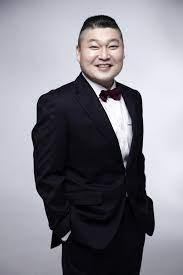

**************************************************


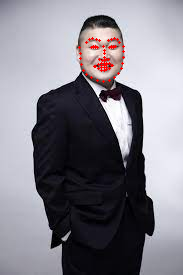

**************************************************


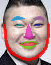

1/1 [==============================] - 1s 762ms/step
**************************************************
고객님의 얼굴형은 하트형 0.0%
고객님의 얼굴형은 긴형 0.0%
고객님의 얼굴형은 계란형 0.0%
고객님의 얼굴형은 둥근형 97.0%
고객님의 얼굴형은 각진형 3.0%
저희가 예측한 고객님의 얼굴형은 둥근형입니다.
**************************************************
고객님의 얼굴형에 추천드리는 헤어스타일은 세미크롭입니다.


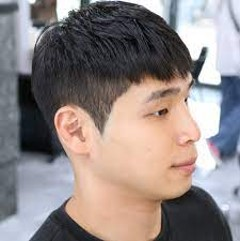

**************************************************
고객님의 얼굴형에 추천드리는 헤어스타일은 스킨페이드컷입니다.


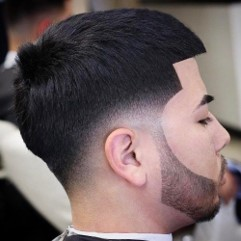

In [6]:
smart_cut_pipeline('/content/drive/MyDrive/bp/model_pipeline/image/강호동.jpg')